In [1]:
# Required packages
import pickle
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

## Patch Classification

### Functions

In [2]:
def create_X_y(patients_dict):
    # Extracts features, labels, and indices from patient patches for model training.
    
    X = []  # Feature list
    y = []  # Label list
    patch_indices = []  # To track which patient and patch each feature corresponds to
    
    # Collect features, labels, and indices for all patches
    for patient_id, patches in patients_dict.items():
        for idx, patch in enumerate(patches[:-1]):            
            X.append(patch['features'])
            y.append(patch['label'])
            patch_indices.append((patient_id, idx))

    return np.array(X), np.array(y), patch_indices

In [3]:
def exploring_estimators(X, y, patients=False):
    """Evaluates multiple classifiers using cross-validation and displays confusion matrices and reports.
    """
    # Define classifiers
    estimators = [
        ('SVM', SVC()),
        ('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
        ('Gaussian Naive Bayes', GaussianNB())
    ]       

    if patients:
        estimators = [        
        ('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
        ('Gaussian Naive Bayes', GaussianNB())
    ]   
        
    names = ['Sane', 'Infected']

    all_estimators = estimators.copy()
    all_estimators.append(('Voting', VotingClassifier(estimators=estimators, voting='hard')))

    # Evaluate each estimator
    for name, estimator in all_estimators:
        predictions = cross_val_predict(estimator, X, y, cv=5)  # Cross-validated predictions
        
        # Display confusion matrix
        print(f'CLASSIFIER USED: {name}')
        cm = confusion_matrix(y, predictions)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names).plot(cmap='Blues')
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        # Display classification report
        print("Classification Report:")
        print(classification_report(y, predictions, target_names=names))
        print('\n' + '='*50 + '\n')


In [4]:
def inference_pass(patients_dict, X, y, patch_indices, estimator, labelled=False):
    """Performs inference with a given estimator and optionally trains it on labeled data.
    """
    # Train estimator if labels are provided
    if labelled:
        estimator.fit(X, y)
    
    # Make predictions
    predictions = estimator.predict(X)
    
    # Store predictions in patients_dict
    for (patient_id, patch_idx), prediction in zip(patch_indices, predictions):
        patients_dict[patient_id][patch_idx]['prediction'] = prediction

    print("Predictions have been stored in the dictionary.")

    return estimator if labelled else None

### Test set

In [5]:
# Load test set from pickle
with open('test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [6]:
# Load patches from test set
X, y, patch_indices = create_X_y(test_set)

CLASSIFIER USED: SVM


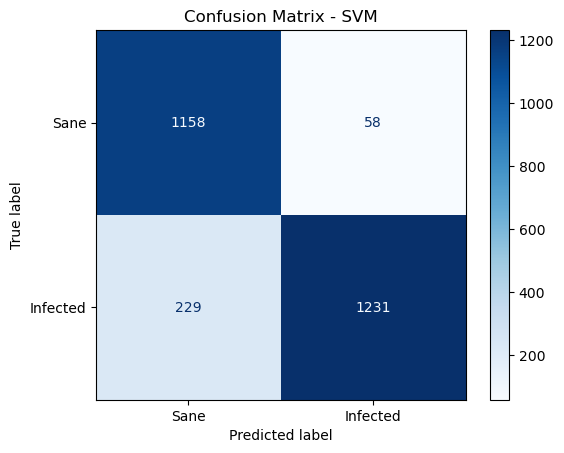

Classification Report:
              precision    recall  f1-score   support

        Sane       0.83      0.95      0.89      1216
    Infected       0.96      0.84      0.90      1460

    accuracy                           0.89      2676
   macro avg       0.89      0.90      0.89      2676
weighted avg       0.90      0.89      0.89      2676



CLASSIFIER USED: Random Forest


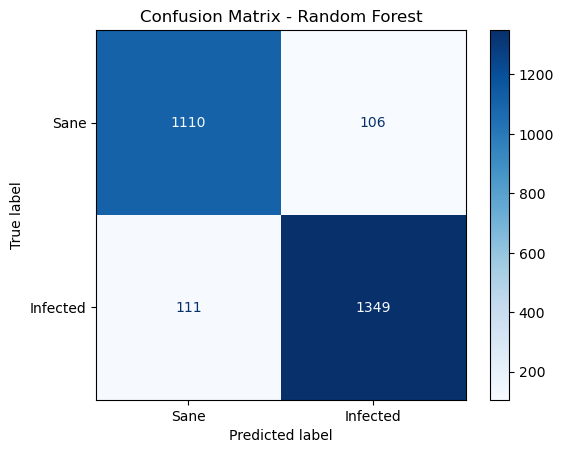

Classification Report:
              precision    recall  f1-score   support

        Sane       0.91      0.91      0.91      1216
    Infected       0.93      0.92      0.93      1460

    accuracy                           0.92      2676
   macro avg       0.92      0.92      0.92      2676
weighted avg       0.92      0.92      0.92      2676



CLASSIFIER USED: Gradient Boosting


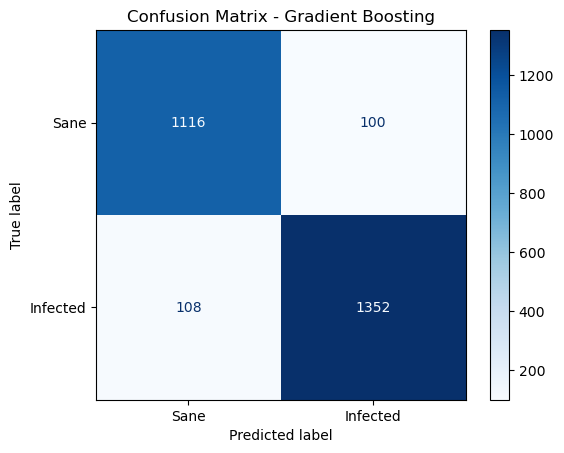

Classification Report:
              precision    recall  f1-score   support

        Sane       0.91      0.92      0.91      1216
    Infected       0.93      0.93      0.93      1460

    accuracy                           0.92      2676
   macro avg       0.92      0.92      0.92      2676
weighted avg       0.92      0.92      0.92      2676



CLASSIFIER USED: Gaussian Naive Bayes


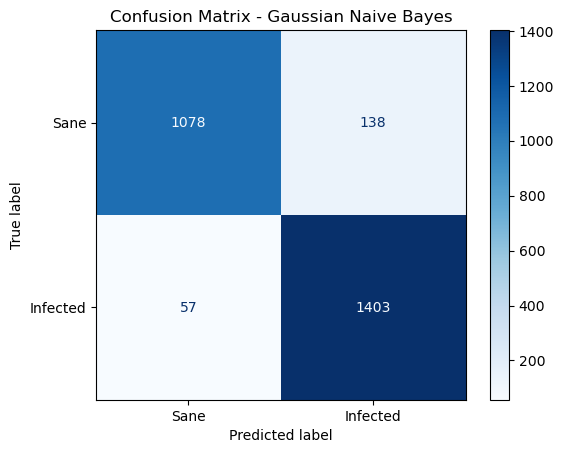

Classification Report:
              precision    recall  f1-score   support

        Sane       0.95      0.89      0.92      1216
    Infected       0.91      0.96      0.94      1460

    accuracy                           0.93      2676
   macro avg       0.93      0.92      0.93      2676
weighted avg       0.93      0.93      0.93      2676



CLASSIFIER USED: Voting


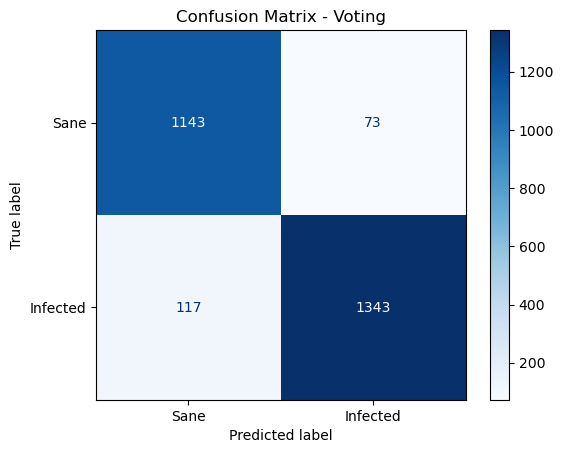

Classification Report:
              precision    recall  f1-score   support

        Sane       0.91      0.94      0.92      1216
    Infected       0.95      0.92      0.93      1460

    accuracy                           0.93      2676
   macro avg       0.93      0.93      0.93      2676
weighted avg       0.93      0.93      0.93      2676





In [7]:
# Test different classifiers on the patches using cross-validation
exploring_estimators(X, y)

Voting classifier seems the best option

In [8]:
# Fit the voting classifier so that we can perform inference
estimators = [
        ('SVM', SVC()),
        ('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
        ('Gaussian Naive Bayes', GaussianNB())
    ]   

voting =  VotingClassifier(estimators=estimators, voting='hard')

# Classify patches of the test set
voting = inference_pass(test_set, X, y, patch_indices, voting, labelled=True)

Predictions have been stored in the dictionary.


In [9]:
test_set['B22-25']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>,
  'features': [0, 0, 1.0],
  'prediction': -1},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>,
  'features': [0, 0, 1.0],
  'prediction': -1},
 {'patient_label': -1}]

### Unseen data

In [10]:
# Load unseen data from pickle
with open('unseen_data.pkl', 'rb') as f:
    unseen_data = pickle.load(f)

In [11]:
# Load patches from unseen data
X, y, patch_indices = create_X_y(unseen_data)

In [12]:
# Classify patches of unseen data
_ = inference_pass(unseen_data, X, y, patch_indices, voting)

Predictions have been stored in the dictionary.


## Patient classification

### Feature extraction

In [13]:
def add_patient_features(patients):
    for patient_id, patches in patients.items():
        # Initialize values for aggregation
        total_red_pixels = 0
        total_difference = 0
        total_percentage_diff = 0
        num_positive_patches = 0
        num_patches = 0

        # Iterate through each patch (dictionary) for the patient
        for patch in patches:
            # Check if the patch has 'features' and 'prediction'
            if 'features' in patch and 'prediction' in patch:
                num_patches += 1
                # Accumulate red pixel counts and differences
                total_red_pixels += patch['features'][0]
                total_difference += patch['features'][1]
                total_percentage_diff += patch['features'][2]
                
                # Count positive patches
                if patch['prediction'] == 1:
                    num_positive_patches += 1
        
        # Calculate mean percentage difference
        mean_percentage_diff = total_percentage_diff / num_patches if num_patches > 0 else 0
        
        # Calculate the percentage of positive patches
        positive_patch_percentage = (num_positive_patches / num_patches) if num_patches > 0 else 0
        
        # Create the patient_features list with the aggregated values and the new feature
        patient_features = [
            total_red_pixels,            # Aggregated red pixels
            total_difference,            # Aggregated difference
            mean_percentage_diff,        # Mean percentage difference
            positive_patch_percentage    # Percentage of positive patches
        ]
        
        # Append patient_features to the list for each patient
        patches.append({'patient_features': patient_features})

             

In [14]:
# Add patient features to test set
add_patient_features(test_set)

In [15]:
test_set['B22-25']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>,
  'features': [0, 0, 1.0],
  'prediction': -1},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>,
  'features': [0, 0, 1.0],
  'prediction': -1},
 {'patient_label': -1},
 {'patient_features': [0, 0, 1.0, 0.0]}]

In [16]:
# Add patient features to unseen data
add_patient_features(unseen_data)

In [17]:
unseen_data['B22-01'][-1]

{'patient_features': [980, 980, 0.8108148148148147, 0.026748971193415638]}

### Functions

In [18]:
def create_pat_X_y(patients_dict):
    # Extracts features, labels, and indices from patient features for model training
    
    X = []  # Feature list (from patient features)
    y = []  # Label list (from patient labels)
    patient_indices = []  # To track which patient each feature corresponds to
    
    # Collect features, labels, and indices for each patient
    for patient_id, patches in patients_dict.items():
        # Extract the patient_features and patient_label
        patient_features = patches[-1]['patient_features']        
        patient_label = patches[-2]['patient_label']
        
        # Add to lists
        X.append(patient_features)
        y.append(patient_label)
        patient_indices.append(patient_id)

    return np.array(X), np.array(y), patient_indices,

In [19]:
def inference_pat_pass(patients_dict, X, y, patient_indices, estimator, labelled=False):
    """Performs inference with a given estimator and optionally trains it on labeled data (patient-level).     
    """
    # Train estimator if labels are provided
    if labelled:
        estimator.fit(X, y)
    
    # Make predictions
    predictions = estimator.predict(X)
    
    # Store predictions as a new element in the patient's list
    for patient_id, prediction in zip(patient_indices, predictions):
        # Create a new entry with the 'ML_prediction'
        new_entry = {'ML_prediction': prediction}
        # Append the new entry to the patient's list
        patients_dict[patient_id].append(new_entry)

    print("Predictions have been stored in the dictionary as a new element with 'ML_prediction'.")

    return estimator if labelled else None

### Test set

In [20]:
# Load patients from test set
X, y, patient_indices = create_pat_X_y(test_set)

CLASSIFIER USED: Random Forest


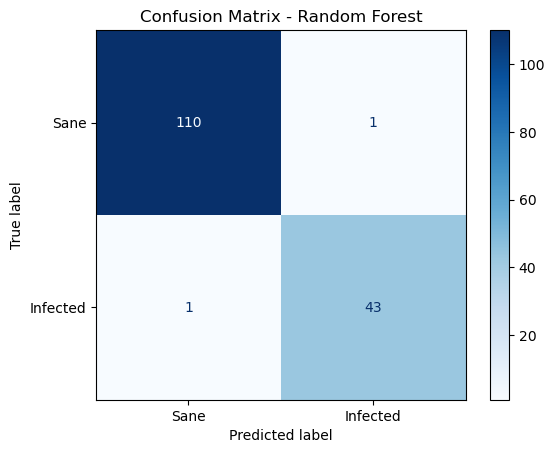

Classification Report:
              precision    recall  f1-score   support

        Sane       0.99      0.99      0.99       111
    Infected       0.98      0.98      0.98        44

    accuracy                           0.99       155
   macro avg       0.98      0.98      0.98       155
weighted avg       0.99      0.99      0.99       155



CLASSIFIER USED: Gradient Boosting


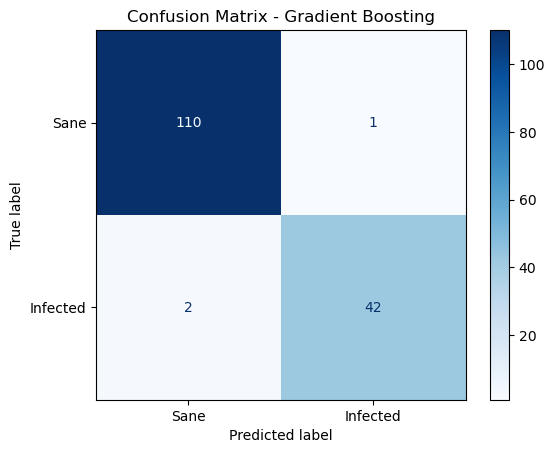

Classification Report:
              precision    recall  f1-score   support

        Sane       0.98      0.99      0.99       111
    Infected       0.98      0.95      0.97        44

    accuracy                           0.98       155
   macro avg       0.98      0.97      0.98       155
weighted avg       0.98      0.98      0.98       155



CLASSIFIER USED: Gaussian Naive Bayes


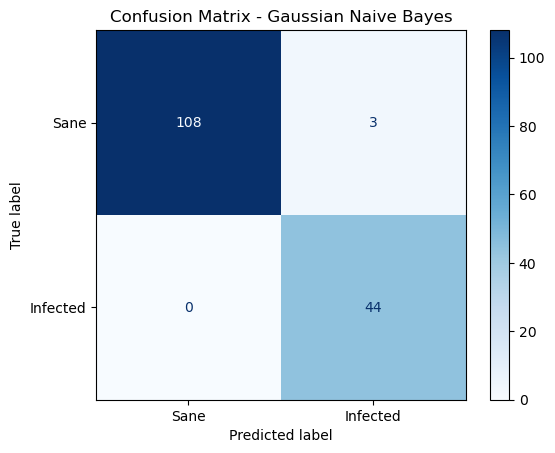

Classification Report:
              precision    recall  f1-score   support

        Sane       1.00      0.97      0.99       111
    Infected       0.94      1.00      0.97        44

    accuracy                           0.98       155
   macro avg       0.97      0.99      0.98       155
weighted avg       0.98      0.98      0.98       155



CLASSIFIER USED: Voting


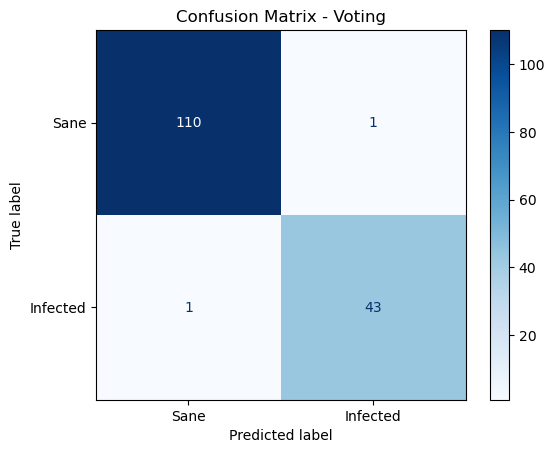

Classification Report:
              precision    recall  f1-score   support

        Sane       0.99      0.99      0.99       111
    Infected       0.98      0.98      0.98        44

    accuracy                           0.99       155
   macro avg       0.98      0.98      0.98       155
weighted avg       0.99      0.99      0.99       155





In [21]:
# Test different classifiers on the patches using cross-validation
exploring_estimators(X, y, patients=True)

Voting classifier seems again the best option

In [22]:
# Fit the voting classifier so that we can perform inference, without SVM that did not perform well
estimators = [        
        ('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
        ('Gaussian Naive Bayes', GaussianNB())
    ]   

voting =  VotingClassifier(estimators=estimators, voting='hard')

# Classify patches of the test set
voting = inference_pat_pass(test_set, X, y, patient_indices, voting, labelled=True)

Predictions have been stored in the dictionary as a new element with 'ML_prediction'.


In [23]:
test_set['B22-25']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>,
  'features': [0, 0, 1.0],
  'prediction': -1},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>,
  'features': [0, 0, 1.0],
  'prediction': -1},
 {'patient_label': -1},
 {'patient_features': [0, 0, 1.0, 0.0]},
 {'ML_prediction': -1}]

### Unseen data

In [24]:
# Load patients from unseen data
X, y, patient_indices = create_pat_X_y(unseen_data)

In [ ]:
# Classify patients of unseen data
_ = inference_pat_pass(unseen_data, X, y, patient_indices, voting)

Predictions have been stored in the dictionary as a new element with 'ML_prediction'.


### Results over unseen data

In [26]:
def compare_predictions(patients_dict):
    """Compares 'ML_prediction' to 'patient_label' and computes confusion matrix metrics."""
    
    # Initialize lists to hold the true labels and predictions
    true_labels = []    
    ml_predictions = []    

    for patient_id, patches in patients_dict.items():
        # The last element in the patient's list contains the 'ML_prediction'
        patient_ml_prediction = patches[-1]['ML_prediction']        
        patient_label = patches[-3]['patient_label']
        
        if patient_label is None:
            print(f"Patient {patient_id} is missing the ground truth label.")            
        
        # Append the true labels and prediction
        true_labels.append(patient_label)
        ml_predictions.append(patient_ml_prediction)        

        # Compare ML_prediction and patch_prediction to the patient_label
        ml_correct = (patient_ml_prediction == patient_label)

    # Calculate confusion matrix for predictions    
    cm_ml = confusion_matrix(true_labels, ml_predictions)
    ConfusionMatrixDisplay(confusion_matrix=cm_ml, display_labels=['Sane', 'Infected']).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - ML prediction")
    plt.show()
    # Display classification report
    print("Classification Report:")
    print(classification_report(true_labels, ml_predictions, zero_division=0, target_names=['Sane', 'Infected']))
    print('\n' + '='*50 + '\n')   

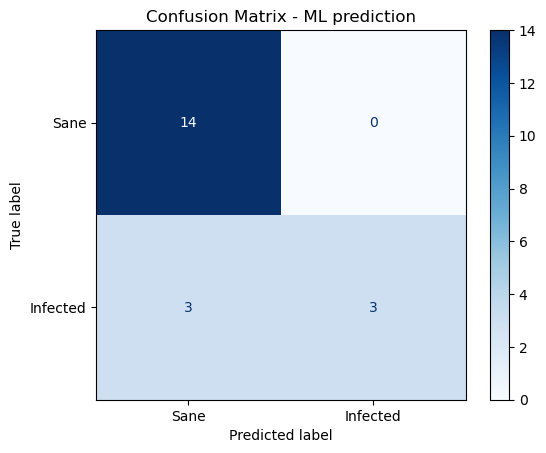

Classification Report:
              precision    recall  f1-score   support

        Sane       0.82      1.00      0.90        14
    Infected       1.00      0.50      0.67         6

    accuracy                           0.85        20
   macro avg       0.91      0.75      0.78        20
weighted avg       0.88      0.85      0.83        20





In [27]:
# Assess patient classification over unseen data
compare_predictions(unseen_data)

### Save final datasets

In [28]:
# Rewrite datasets
with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)
with open('unseen_data.pkl', 'wb') as f:
    pickle.dump(unseen_data, f)